# **Data Mining Project 2025/2026 - Group 94** <br> Amazing International Airlines Inc.


**Diogo Henrique Lopes de Carvalho** ***(20221935)***

**Maria Luiza Salum Alves Corrêa** ***(20221902)***

**Ricardo Miguel Silva Martins Pereira** ***(20250343)***

*** 

## **Index**

***First Delivery***
1. [Business Understanding](#1)
1. [Imports](#2)
1. [Data Analysis](#3)
    1. [The Dataset](#3_1)
    1. [Data Interpretation](#3_2)
1. [Data Preparation - Exploratory Data Analysis (EDA)](#4)
    1. [Data Cleaning](#4_1)
    1. [Variable Classification](#4_2)
    1. [Summary Statistics](#4_3)
    1. [Data Visualisation](#4_4)

***Second Delivery***

5. [Clustering](#5)
5. [Evaluation](#6)
5. [Suggestions](#7)

#
***

## 1. <a id="1">Business Understanding</a>

Our client, **Amazing International Airlines Inc.**, tasked our consulting team with the analysis of their customer loyalty membership data and corresponding flight activity collected over a three-year period. <br>

The goal of our analysis is to create useful insights through a segmentation process that consists of grouping and viewing the available data by different lenses; such as *economic contribution*, *behaviours in purchases and travels*, and *demographic divisions*. <br>

After sharing the insights, our team will evaluate the results and give AIAI suggestions on how to adapt their services, rewards and communications to meet the needs of the most relevant groups found.

***

## 2. <a id="2">Imports</a>

In [609]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import product
from sklearn.impute import KNNImputer

# import itertools

***

## 3. <a id="3">Data Analysis</a>

### 1. <a id="3_1">The Dataset</a>

The dataset given to our team consists of three `csv` files:

- `DM_AIAI_CustomerDB.csv`

*Three (3) years of data related to Customers in the Loyalty Program*
- `DM_AIAI_FlightsDB.csv`

*Three (3) years of data related to Flights of the Loyalty Program Members*
- `DM_AIAI_Metadata.csv`

*Description of the Variables in the CustomerDB and FlightDB Files*

In [610]:
customerDB = pd.read_csv(r'data\DM_AIAI_CustomerDB.csv', sep=',')
flightDB = pd.read_csv(r'data\DM_AIAI_FlightsDB.csv', sep=',')
metadata = pd.read_csv(r'data\DM_AIAI_Metadata.csv', sep=';')

customerDB_copy = customerDB.copy()
flightDB_copy = flightDB.copy()

In [611]:
pd.set_option('display.max_colwidth', None)  # To see full descriptions
metadata

,CustomerDB,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Variable,Description,NaN
1,NaN,Loyalty#,Unique customer identifier for loyalty program members,NaN
2,NaN,First Name,Customer's first name,NaN
3,NaN,Last Name,Customer's last name,NaN
4,NaN,Customer Name,Customer's full name (concatenated),NaN
5,NaN,Country,Customer's country of residence,NaN
6,NaN,Province or State,Customer's province or state,NaN
7,NaN,City,Customer's city of residence,NaN
8,NaN,Latitude,Geographic latitude coordinate of customer location,NaN
9,NaN,Longitude,Geographic longitude coordinate of customer location,NaN


#### Initial Conclusions - Feature Selection
*What conclusions can we make from the metadata?*

##### Customer DB

**Useful:**
- `Loyalty#`: Will be used. Connects Customer's and Flights' information.

**Will be Dropped:**
- `First Name`, `Last Name`, `Customer Name`: First two are redundant since we have the full name, but this information is irrelevant for clustering anyways. We'll drop everything after data cleaning. *(Keeping `Customer Name` for now to check something with the IDs)*
- `Latitude`, `Longitude`, `Postal code`: No need for specific customer location. *(Spoilers: We checked, some coordinates lead to nowhere and just make no sense overall)*

**No Conclusions:** <br>
*May be relevant. No conclusions about data quality from metadata.*
- `Country`
- `Province or State`
- `City`
- `Postal Code`
- `Gender`
- `Education`
- `Location Code`
- `Income`
- `Marital Status`
- `Loyalty Status`
- `EnrollmentDataOpening`
- `CancellationDate`
- `Customer Lifetime Value`
- `EnrollmentType`

In [612]:
customerDB_copy.drop(columns=['First Name', 'Last Name', 'Latitude', 'Longitude', 'Postal code'], inplace=True)
customerDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16921 entries, 0 to 16920
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               16921 non-null  int64  
 1   Loyalty#                 16921 non-null  int64  
 2   Customer Name            16921 non-null  object 
 3   Country                  16921 non-null  object 
 4   Province or State        16921 non-null  object 
 5   City                     16921 non-null  object 
 6   Gender                   16921 non-null  object 
 7   Education                16921 non-null  object 
 8   Location Code            16921 non-null  object 
 9   Income                   16901 non-null  float64
 10  Marital Status           16921 non-null  object 
 11  LoyaltyStatus            16921 non-null  object 
 12  EnrollmentDateOpening    16921 non-null  object 
 13  CancellationDate         2310 non-null   object 
 14  Customer Lifetime Valu

From the non-null count, we can see that there are only three variables with missing values: `Income`, `CancellationDate` and `Customer Lifetime Value`. Having null values in `CancellationDate` clearly makes sense as we don't expect all customers in the dataset to have cancelled their membership. For `Income` and `Customer Lifetime Value`, we'll try to understand the reason later.

In [613]:
# There's a random column with no name, let's drop it
customerDB_copy.drop(columns=['Unnamed: 0'], inplace=True)

##### Flights DB

**Useful:**
- `Loyalty#`: Will be used. Connects Customer's and Flights' information.

**Will be Dropped:**
- `YearMonthDate`: Contains the same info as `Month` and `Year` with a constant date.
- `DollarCostPointsRedeemed`: Redundant. `PointsRedeemed` gives the same information.

**No Conclusions:** <br>
*May be relevant. No conclusions about data quality from metadata.*
- `Year`
- `Month`
- `NumFlights`
- `NumFlightsWithCompanions`*
- `DistanceKM`
- `PointsAccumulated`
- `PointsRedeemed`

**We will assume `NumFlightsWithCompanions` is also a "count by month" even though it's not mentioned in the metadata.*

In [614]:
flightDB_copy.drop(columns=['YearMonthDate', 'DollarCostPointsRedeemed'], inplace=True)
flightDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   NumFlights                608436 non-null  float64
 4   NumFlightsWithCompanions  608436 non-null  float64
 5   DistanceKM                608436 non-null  float64
 6   PointsAccumulated         608436 non-null  float64
 7   PointsRedeemed            608436 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 37.1 MB


There are no null values in any variable. We'll take a closer look into the dataset when preparing the data. There might be missing values that are non-null since they could look like "-", "Null", "Missing", etc.

### 2. <a id="3_2">Data Interpretation</a>

<div class="alert alert-block alert-info">
ADD YAPPING SESSION HERE
</div>

***

## 4. <a id="4">Data Preparation - Exploratory Data Analysis (EDA)</a>

There's a possibility of having some rows that the only plausible option is removing them from the dataset due to uncorrectable errors. For this reason, we are going to define variables to keep track of how many rows we are dropping.

We are going to assume that an acceptable threshold is 3% of the dataset.

In [615]:
customer_dropped_rows = 0
customer_original_rows = customerDB.shape[0]
customer_dropped_percentage = 0
customer_available_to_drop = (customer_original_rows * 0.03) - customer_dropped_rows
print(f"Available rows to drop in customerDB: {customer_available_to_drop} ({(customer_available_to_drop/customer_original_rows)*100:.0f}%)")

flight_dropped_rows = 0
flight_original_rows = flightDB.shape[0]
flight_dropped_percentage = 0
flight_available_to_drop = (flight_original_rows * 0.03) - flight_dropped_rows
print(f"Available rows to drop in flightDB: {flight_available_to_drop} ({(flight_available_to_drop/flight_original_rows)*100:.0f}%)")

Available rows to drop in customerDB: 507.63 (3%)
Available rows to drop in flightDB: 18253.079999999998 (3%)


In [616]:
customerDB_copy.head()

,Loyalty#,Customer Name,Country,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia Householder,Canada,Ontario,Toronto,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle Menez,Canada,Alberta,Edmonton,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole Hannon,Canada,British Columbia,Vancouver,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,608370,Queen Hagee,Canada,Ontario,Toronto,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,530508,Claire Latting,Canada,Quebec,Hull,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [617]:
# Seeing the different values in each variable and if they're less than 15, printing them bellow
for variable in customerDB_copy.columns:
    print(f"{variable}: {customerDB_copy[variable].nunique()} unique values\n")
    if customerDB_copy[variable].nunique() < 15:
        print(f"{customerDB_copy[variable].value_counts()}\n")

Loyalty#: 16757 unique values

Customer Name: 16921 unique values

Country: 1 unique values

Country
Canada    16921
Name: count, dtype: int64

Province or State: 11 unique values

Province or State
Ontario                 5468
British Columbia        4416
Quebec                  3311
Alberta                 1008
Manitoba                 676
New Brunswick            652
Nova Scotia              541
Saskatchewan             412
Newfoundland             258
Yukon                    112
Prince Edward Island      67
Name: count, dtype: int64

City: 29 unique values

Gender: 2 unique values

Gender
female    8497
male      8424
Name: count, dtype: int64

Education: 5 unique values

Education
Bachelor                10586
College                  4283
High School or Below      792
Doctor                    742
Master                    518
Name: count, dtype: int64

Location Code: 3 unique values

Location Code
Suburban    5716
Rural       5668
Urban       5537
Name: count, dtype: int64

Inc

In [618]:
flightDB_copy.head()

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
0,413052,2021,12,2.0,2.0,9384.0,938.0,0.0
1,464105,2021,12,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,10.0,3.0,14745.0,1474.0,0.0
3,185013,2021,12,16.0,4.0,26311.0,2631.0,3213.0
4,216596,2021,12,9.0,0.0,19275.0,1927.0,0.0


In [619]:
# Seeing the different values in each variable and if they're less than 15, printing them bellow
for variable in flightDB_copy.columns:
    print(f"{variable}: {flightDB_copy[variable].nunique()} unique values\n")
    if flightDB_copy[variable].nunique() < 15:
        print(f"{flightDB_copy[variable].value_counts()}\n")

Loyalty#: 16737 unique values

Year: 3 unique values

Year
2021    202812
2020    202812
2019    202812
Name: count, dtype: int64

Month: 12 unique values

Month
12    50703
6     50703
5     50703
4     50703
3     50703
2     50703
1     50703
11    50703
10    50703
9     50703
8     50703
7     50703
Name: count, dtype: int64

NumFlights: 41 unique values

NumFlightsWithCompanions: 22 unique values

DistanceKM: 66762 unique values

PointsAccumulated: 37064 unique values

PointsRedeemed: 8146 unique values



### 1. <a id="4_1">Data Cleaning</a>

##### Loyalty# *(+ Customer Name)*

In [620]:
# Confirming how many rows have repeated Loyalty#
print(customerDB_copy['Loyalty#'].duplicated().sum())
# Confirming if the whole row is duplicated
print(customerDB_copy.duplicated().sum())

164
0


We kept `Customer Name` before so we could check if they're the same for repeated Loyalty IDs, but this is not the case as the unique values count is 16921. This means that we cannot use the name to fix the issue with duplicated IDs (they're not the same person).

We could assign new random values to the repeated IDs, but the FlightsDB dataset is connected to each customer through this variable, so it makes no sense to change it in the CustomerDB since this would mean that they have no associated flights.

We'll now drop `Customer Name` and remove the rows with repeated Loyalty ID.

In [621]:
# Dropping Customer Name
customerDB_copy.drop(columns=['Customer Name'], inplace=True)

In [622]:
# Keeping only one of the duplicated rows and adding the number of dropped rows to the counter
for loyalty_id in customerDB_copy['Loyalty#'][customerDB_copy['Loyalty#'].duplicated()]: # for each duplicated Loyalty#
    duplicated_rows = customerDB_copy[customerDB_copy['Loyalty#'] == loyalty_id] # getting the duplicated rows
    customerDB_copy.drop(duplicated_rows.index[1:], inplace=True) # dropping from the second to the last (just in case there are more than 2)
    customer_dropped_rows += len(duplicated_rows) - 1 # adding the number of dropped rows to the counter
    
customer_dropped_percentage = customer_dropped_rows / customer_original_rows * 100
customer_available_to_drop -= customer_dropped_rows
print(f"Total dropped rows: {customer_dropped_rows}, which is {customer_dropped_percentage:.2f}% of the original dataset. We can still drop {customer_available_to_drop} rows.")

Total dropped rows: 164, which is 0.97% of the original dataset. We can still drop 343.63 rows.


##### Country

`Country` is a constant feature (Canada). We'll drop this column.

In [623]:
# Dropping Country 
customerDB_copy.drop(columns=['Country'], inplace=True)

#### City

Checking if all cities in the list are Canadian cities.

In [624]:
customerDB_copy['City'].unique()

array(['Toronto', 'Edmonton', 'Vancouver', 'Hull', 'Whitehorse',
       'Trenton', 'Montreal', 'Dawson Creek', 'Quebec City', 'Moncton',
       'Fredericton', 'Ottawa', 'Tremblant', 'Calgary', 'Whistler',
       'Thunder Bay', 'Peace River', 'Winnipeg', 'Sudbury',
       'West Vancouver', 'Halifax', 'London', 'Victoria', 'Regina',
       'Kelowna', "St. John's", 'Kingston', 'Banff', 'Charlottetown'],
      dtype=object)

#### Income - Customer Lifetime Value

We'll see if the null values in `Income` are related to the null values in `Customer Lifetime Value`.

In [625]:
income_null = customerDB_copy[customerDB_copy['Income'].isnull()]
clv_null = customerDB_copy[customerDB_copy['Customer Lifetime Value'].isnull()]
income_clv_null = customerDB_copy[(customerDB_copy['Income'].isnull()) & (customerDB_copy['Customer Lifetime Value'].isnull())]
print(f"Income null values: {len(income_null)}\nCLV null values: {len(clv_null)}\nBoth null values: {len(income_clv_null)}")

Income null values: 20
CLV null values: 20
Both null values: 20


When using these variables for analysis, we'll ignore these null rows. The remaining customer information is useful for other analyses, so it makes no sense to drop the whole row.

In [626]:
income_zero = customerDB_copy[customerDB_copy['Income'] == 0]
clv_zero = customerDB_copy[customerDB_copy['Customer Lifetime Value'] == 0]
income_clv_zero = customerDB_copy[(customerDB_copy['Income'] == 0) & (customerDB_copy['Customer Lifetime Value'] == 0)]
print(f"Income zero values: {len(income_zero)}\nCLV zero values: {len(clv_zero)}\nBoth zero values: {len(income_clv_zero)}\n")
print(income_zero['Customer Lifetime Value'])

Income zero values: 4238
CLV zero values: 0
Both zero values: 0

1         3839.61
2         3839.75
3         3839.75
6         3857.95
13        3871.07
           ...   
16885    44771.30
16891    52811.49
16895    61134.68
16896    61850.19
16898    74228.52
Name: Customer Lifetime Value, Length: 4238, dtype: float64


We'll try to understand if there's a pattern for the 0€ income values in the Data Visualisation section. Maybe a specific type of customer decided to keep their income a secret..? We don't know yet, but we can see that these customers, even though they have no revealed `Income`, have an estimated CLV.

If there's no pattern, we'll drop the rows with these null values when doing analysis related to `Income`.

#### CancellationDate

Checking if there are dates in `CancellationDate` that are earlier than dates in `EnrollmentDateOpening`.

In [627]:
customerDB_copy['EnrollmentDateOpening'] = pd.to_datetime(customerDB_copy['EnrollmentDateOpening'], errors='coerce')
customerDB_copy['CancellationDate'] = pd.to_datetime(customerDB_copy['CancellationDate'], errors='coerce')
invalid_dates = customerDB_copy[customerDB_copy['CancellationDate'] < customerDB_copy['EnrollmentDateOpening']]
print(f"Number of rows with CancellationDate before EnrollmentDateOpening: {len(invalid_dates)}")
invalid_dates

Number of rows with CancellationDate before EnrollmentDateOpening: 201


,Loyalty#,Province or State,City,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
72,357549,British Columbia,Whistler,female,Bachelor,Rural,60817.0,Single,Star,2021-09-21,2019-05-21,3964.73,Standard
77,265297,Manitoba,Winnipeg,female,Bachelor,Urban,39101.0,Married,Star,2021-07-17,2019-03-17,3978.67,Standard
176,845613,Quebec,Montreal,male,Bachelor,Urban,30598.0,Married,Star,2021-10-13,2019-06-13,4198.03,Standard
210,830547,British Columbia,Vancouver,male,Bachelor,Rural,26245.0,Single,Star,2021-05-11,2019-01-11,4271.20,Standard
304,514900,Ontario,Toronto,female,Bachelor,Urban,80892.0,Married,Star,2021-07-20,2019-03-20,4425.91,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16514,584796,British Columbia,Vancouver,male,Bachelor,Rural,59853.0,Single,Star,2021-08-18,2019-04-18,19454.41,Standard
16522,774931,British Columbia,Whistler,female,Bachelor,Rural,33588.0,Married,Star,2021-07-21,2019-03-21,19731.34,Standard
16551,275807,Manitoba,Winnipeg,female,Bachelor,Urban,71467.0,Divorced,Star,2021-10-18,2019-06-18,20446.60,Standard
16634,433307,Manitoba,Winnipeg,male,Bachelor,Suburban,80540.0,Married,Star,2021-08-03,2019-04-03,22758.91,Standard


We are going to assume that the customer had a previous membership, cancelled it, and then decided to become a member once again.

For this reason, we're just going to replace these dates in `CancellationDate` with Na.

*We're not adding this to the dropped rows count as we only did a replacement.*

In [628]:
for row in invalid_dates:
    customerDB_copy.loc[invalid_dates.index, 'CancellationDate'] = pd.NaT

#### CustomerDB - FlightDB Relation

In [629]:
flightDB_copy.shape[0]/customerDB_copy.shape[0]

36.30936325117861

Every customer in the loyalty program should have a row for each one of the 36 months in the dataset. The number above shows that there are more months registered than customers. We'll take a look into this.

In [630]:
# for each loyalty number, counting how many rows there are in the flights dataset
flight_counts = flightDB_copy['Loyalty#'].value_counts()
loyalty_over_36 = flight_counts[flight_counts > 36]
print(f"Number of Loyalty# with more than 36 rows: {len(loyalty_over_36)}")

# for each loyalty number, counting how many months are missing in the flights dataset
months_per_loyalty = flightDB_copy.groupby('Loyalty#').size()
missing_months = months_per_loyalty[months_per_loyalty < 36]
print(f"Number of Loyalty# with less than 36 months: {len(missing_months)}")

Number of Loyalty# with more than 36 rows: 163
Number of Loyalty# with less than 36 months: 0


In [631]:
# showing the rows for one Loyalty# with more than 36 rows
flightDB_copy[flightDB_copy['Loyalty#'] == loyalty_over_36.index[0]]

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
5211,678205,2020,5,0.0,0.0,0.0,0.0,0.0
11558,678205,2020,5,0.0,0.0,0.0,0.0,0.0
19366,678205,2020,5,0.0,0.0,0.0,0.0,0.0
21029,678205,2020,4,0.0,0.0,0.0,0.0,0.0
22477,678205,2020,4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
585497,678205,2019,11,0.0,0.0,0.0,0.0,0.0
585498,678205,2019,11,0.0,0.0,0.0,0.0,0.0
602397,678205,2019,12,0.0,0.0,0.0,0.0,0.0
602398,678205,2019,12,0.0,0.0,0.0,0.0,0.0


For each repeated month, we'll keep the row with the less amount of null values.

In [632]:
non_null_counts = flightDB_copy.notnull().sum(axis=1) # counting non-null values in each row
row_to_keep = (flightDB_copy.assign(non_null_count=non_null_counts).groupby(['Loyalty#', 'Year', 'Month'])['non_null_count'].idxmax()) # getting the index of the row with the most non-null values for each Loyalty#, Year, Month
flightDB_copy = flightDB_copy.loc[row_to_keep].copy() # keeping only the rows with the most non-null values

# updating the dropped rows counter
flight_dropped_rows = flight_original_rows - flightDB_copy.shape[0]
flight_available_to_drop -= flight_dropped_rows

print(f"Total dropped rows: {flight_dropped_rows}, which is {(flight_dropped_rows/flight_original_rows)*100:.2f}% of the original dataset. We can still drop {flight_available_to_drop} rows.")

Total dropped rows: 5904, which is 0.97% of the original dataset. We can still drop 12349.079999999998 rows.


*Side comment: the same percentage of rows was dropped when we were cleaning the duplicate customers... This could mean that the people dropped in this previous step had an already existing ID assigned to them when creating their account. This would have mixed their data with the other customer with the existing ID.*

*There's no way of identifying which flight information is related to each one of these customers, so we'll need to work with what we have.*

In [633]:
# for each loyalty number, counting how many rows there are in the flights dataset
flight_counts = flightDB_copy['Loyalty#'].value_counts()
loyalty_over_36 = flight_counts[flight_counts > 36]
print(f"Number of Loyalty# with more than 36 rows: {len(loyalty_over_36)}")

# for each loyalty number, counting how many months are missing in the flights dataset
months_per_loyalty = flightDB_copy.groupby('Loyalty#').size()
missing_months = months_per_loyalty[months_per_loyalty < 36]
print(f"Number of Loyalty# with less than 36 months: {len(missing_months)}")

Number of Loyalty# with more than 36 rows: 0
Number of Loyalty# with less than 36 months: 0


### 2. <a id="4_2">Variable Classification</a>

*It makes no sense to make `Loyalty#` the index in the flightDB dataset as the same customer may have multiple flights.*

In [634]:
# Making Loyalty# the index for the customerDB
customerDB_copy.set_index('Loyalty#', inplace=True)

We're going to categorise the different variables in both datasets.


For `customerDB`, we'll have Nominal, Ordinal, Numerical, and DateTime variables. We're diving the categorical variables in Nominal and Ordinal because the latter will have its variables used for the Encoded category.

For `flightDB`, we'll only have Numerical and DateTime variables since this dataset has no categorical variables.

In [635]:
customerDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16757 entries, 480934 to 100016
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Province or State        16757 non-null  object        
 1   City                     16757 non-null  object        
 2   Gender                   16757 non-null  object        
 3   Education                16757 non-null  object        
 4   Location Code            16757 non-null  object        
 5   Income                   16737 non-null  float64       
 6   Marital Status           16757 non-null  object        
 7   LoyaltyStatus            16757 non-null  object        
 8   EnrollmentDateOpening    16757 non-null  datetime64[ns]
 9   CancellationDate         2085 non-null   datetime64[ns]
 10  Customer Lifetime Value  16737 non-null  float64       
 11  EnrollmentType           16757 non-null  object        
dtypes: datetime64[ns](2), float64(2

In [636]:
customer_nominal_variables = ['Province or State', 'City', 'Gender', 'Location Code', 'Marital Status', 'EnrollmentType']
customer_ordinal_variables = ['Education', 'LoyaltyStatus']
customer_numerical_variables = customerDB_copy.select_dtypes(include=[np.number]).columns.tolist()
customer_datetime_variables = customerDB_copy.select_dtypes(include=['datetime']).columns.tolist()

In [637]:
# Encoding ordinal variables
education_map = {'Bachelor':3, 'College':2, 'High School or Below':1, 'Doctor':5, 'Master':4}
loyaltystatus_map = {'Star':1, 'Nova':2, 'Aurora':3}
for variable in customer_ordinal_variables:
    if variable == 'Education':
        customerDB_copy['Education Encoded'] = customerDB_copy[variable].map(education_map)
    elif variable == 'LoyaltyStatus':
        customerDB_copy['LoyaltyStatus Encoded'] = customerDB_copy[variable].map(loyaltystatus_map)
customer_ordinal_variables_encoded = ['Education Encoded', 'LoyaltyStatus Encoded'] # New list of encoded ordinal variables

In [638]:
flightDB_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 602532 entries, 405624 to 169662
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  602532 non-null  int64  
 1   Year                      602532 non-null  int64  
 2   Month                     602532 non-null  int64  
 3   NumFlights                602532 non-null  float64
 4   NumFlightsWithCompanions  602532 non-null  float64
 5   DistanceKM                602532 non-null  float64
 6   PointsAccumulated         602532 non-null  float64
 7   PointsRedeemed            602532 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 41.4 MB


In [639]:
flight_numerical_variables = flightDB_copy.select_dtypes(include=['float']).columns.tolist()
flight_date_variables = ['Year', 'Month']

*We could change `Year` and `Month` into a datetime column, but we figured they would be more useful for analysis as separate variables.*

### 3.<a id="4_3"> Summary Statistics</a>

In [640]:
customerDB_copy[customer_ordinal_variables].describe().T

,count,unique,top,freq
Education,16757,5,Bachelor,10483
LoyaltyStatus,16757,3,Star,7657


In [641]:
customerDB_copy[customer_numerical_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,16737.0,37749.877696,30370.336552,0.00,0.00,34148.00,62396.00,99981.00
Customer Lifetime Value,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38


`Customer Lifetime Value` seems to have outliers on the right, as the mean is higher than the median. This means that *some* customers have a high Lifetime Value, but the majority doesn't. It makes sense from a logical point of view as we don't see most people having frequent flights. However, we'll try to understand how this variable relates to the rest in the Data Visualisation section.

As said previously, in clustering, we will try to understand if there's a pattern in the missing values in `Income`. *(i.e. If they're missing completely at random, at random or not at random)*

In [642]:
flightDB_copy[flight_numerical_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
NumFlights,602532.0,3.917947,5.061262,0.0,0.0,0.900,7.2000,21.0
NumFlightsWithCompanions,602532.0,0.985944,2.005278,0.0,0.0,0.000,0.9000,11.0
DistanceKM,602532.0,7955.196144,10263.557090,0.0,0.0,919.000,15367.0000,42040.0
PointsAccumulated,602532.0,795.362893,1026.232111,0.0,0.0,91.845,1536.3225,4204.0
PointsRedeemed,602532.0,235.805094,984.379949,0.0,0.0,0.000,0.0000,7496.0


In the Flights dataset, we can see that most variables have many rows with null values.

We can conclude that 25% of the registered *months by customer* have no flights. This could mean that some months have few or no flights or that some customers have no flights in most or all months.

The `NumFlightsWithCompanions` variable is clearly related to the `NumFlights`, as one indicates the number of flights *with companions* and the other the number of flights the customer had in the month in total, respectively, so it makes sense that it has even more null values (at least 50%).

The remaining values follow the same logic. They're all related to the total number of flights, so it makes sense that at least 25% of their values are null since 25% of `NumFlights`'s values is also null.

`PointsRedeemed` and `DollarCostPointsRedeemed` also show that most customers (75% or more) don't redeem their available points.

Overall, we can conclude that every numerical variable of this dataset is left-skewed as the mean is much higher than the median in every case.

### 4.<a id="4_4"> Data Visualisation</a>

In [643]:
sns.set_palette('pastel')

#### Zero-Income Pattern Analysis

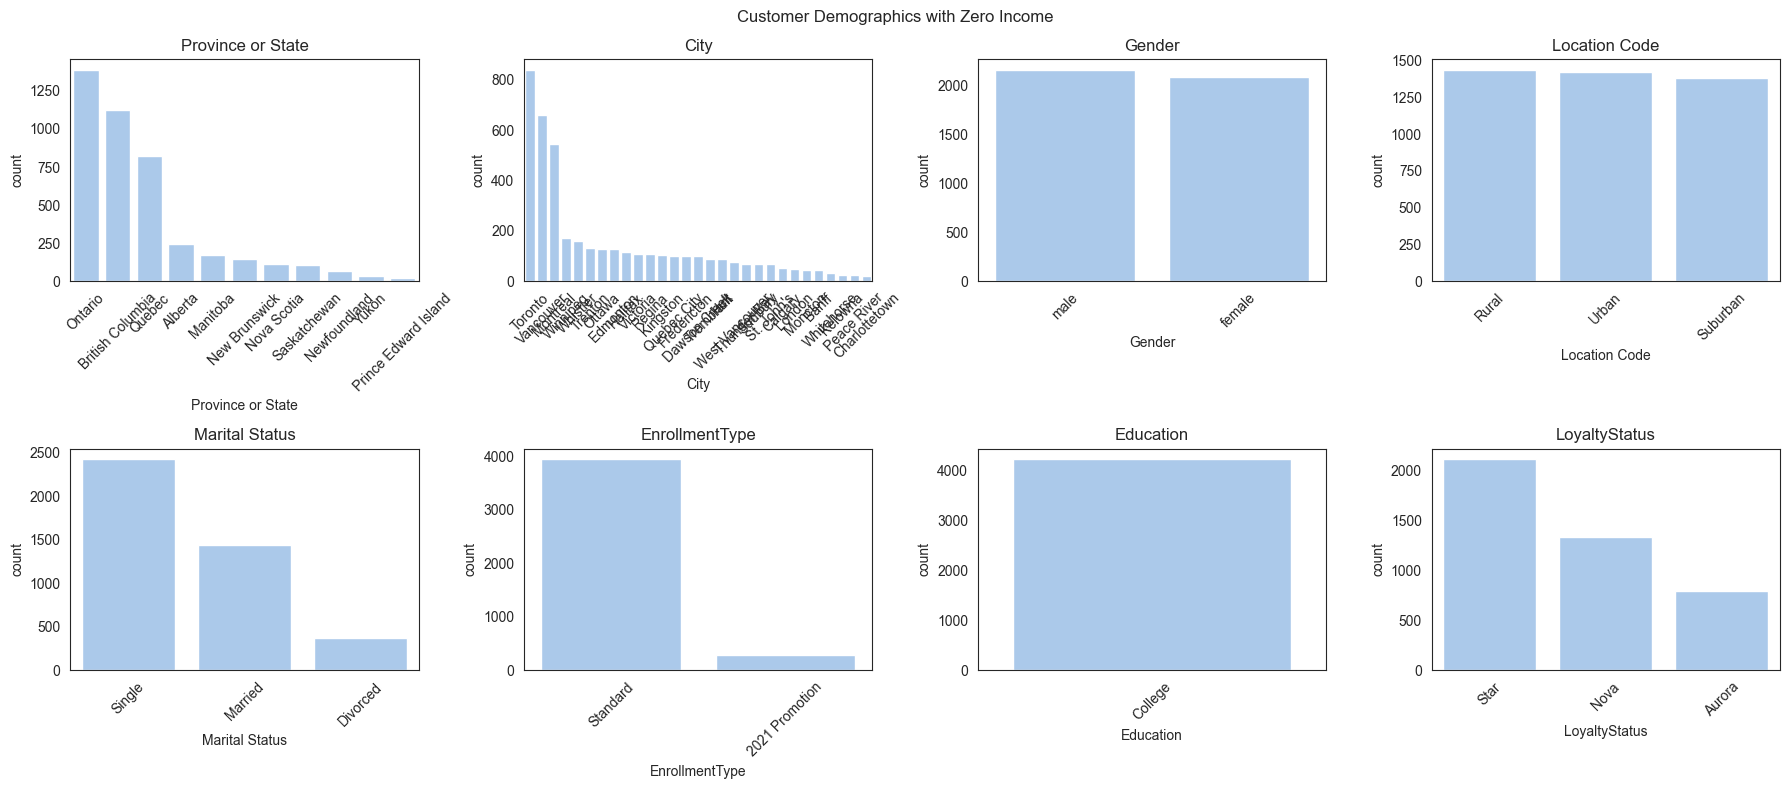

In [644]:
# graphs to see what kind of customer has zero income
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()
for i, variable in enumerate(customer_nominal_variables + customer_ordinal_variables):
    sns.countplot(data=customerDB_copy[customerDB_copy['Income'] == 0], x=variable, order=customerDB_copy[customerDB_copy['Income'] == 0][variable].value_counts().index, ax=axes[i])
    axes[i].set_title(variable)
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle("Customer Demographics with Zero Income")
plt.tight_layout()
plt.show()

We can see here that `Education` is the variable where we only have one category with zero-income value. From a logical point of view, this makes sense, as people who are currently in college (apart from student-workers) don't have a fixed income. We'll replace the zero values with null.

In [645]:
# Just checking to see how many college-educated customers have non-zero and non-null income
college_count = customerDB_copy[customerDB_copy['Education'] == 'College'].shape[0]
college_zero_income_count = income_zero[income_zero['Education'] == 'College'].shape[0]
college_null_income_count = income_null[income_null['Education'] == 'College'].shape[0]
remaining_college_income_count = college_count - (college_zero_income_count + college_null_income_count)
print(remaining_college_income_count)

0


In [646]:
customerDB_copy.loc[customerDB_copy['Income'] == 0, 'Income'] = np.nan

#### Customer Lifetime Value Correlations

We will use different correlations when comparing different variable types with the CLV.

Continuous Variables - Spearman: `Income`, `NumFlights`, `NumFlightsWithCompanions`, `DistanceKM`, `PointsAccumulated`, `PointsRedeemed`

*(We will not use Pearson since our variables don't have normal distribution.)*

Ordinal Variables - Spearman: `Education Encoded`, `LoyaltyStatus Encoded`

Correlation Ratio - Categorical Variables: `Education`, `LoyaltyStatus`, `Gender`, `Location Code`, `Marital Status`, `EnrollmentType`

In [647]:
# Merging the two datasets to make the correlations easier
merged_df = customerDB_copy.merge(flightDB_copy, left_index=True, right_on='Loyalty#', how='left')

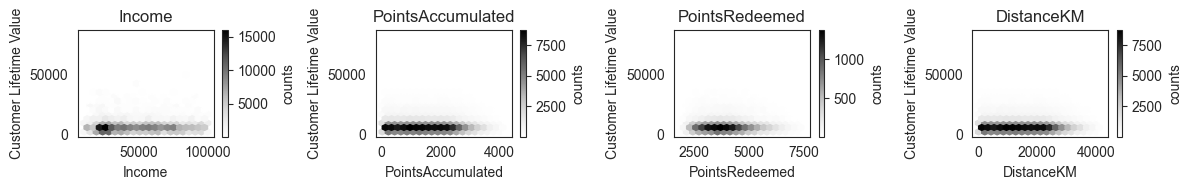

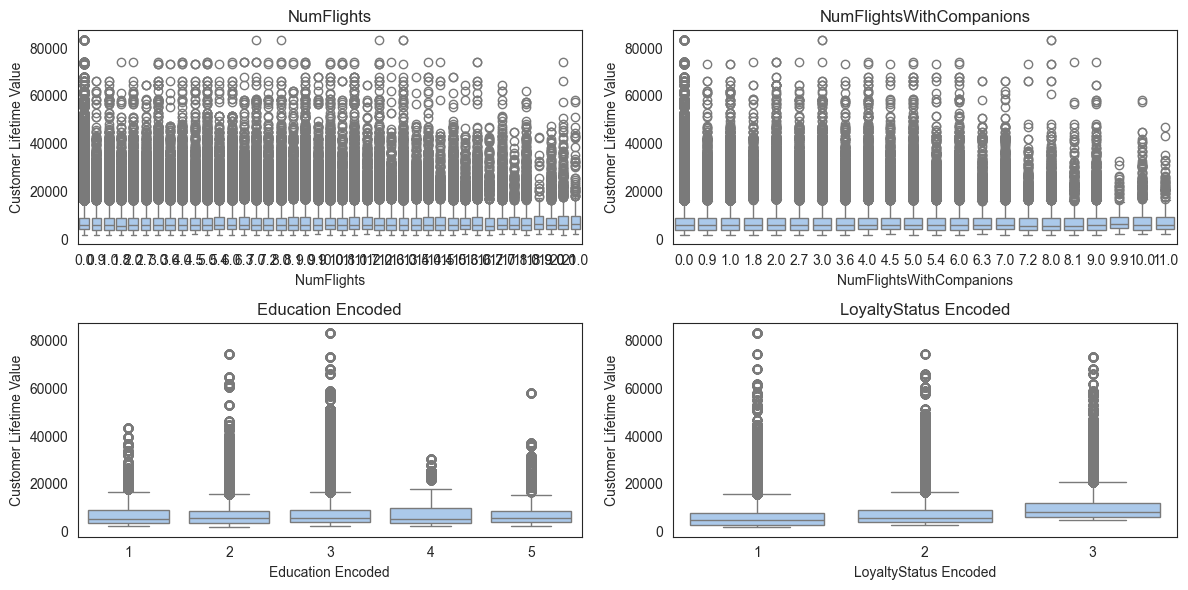

In [648]:
continuous_vars = ['Income', 'PointsAccumulated', 'PointsRedeemed', 'DistanceKM']
discrete_ord_vars = ['NumFlights', 'NumFlightsWithCompanions', "Education Encoded", 'LoyaltyStatus Encoded']

sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2))
axes = axes.flatten()
for i, var in enumerate(continuous_vars):
    hb = axes[i].hexbin(merged_df[merged_df[var] != 0][var], merged_df[merged_df[var] != 0]['Customer Lifetime Value'], gridsize=20, cmap='Greys', mincnt=1)
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Customer Lifetime Value')
    cb = fig.colorbar(hb, ax=axes[i], label='counts')
plt.tight_layout()
plt.show()

fig_2, axes_2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes_2 = axes_2.flatten()
for i, var in enumerate(discrete_ord_vars):
    sns.boxplot(x=merged_df[var], y=merged_df['Customer Lifetime Value'], ax=axes_2[i])
    axes_2[i].set_title(var)
    axes_2[i].set_xlabel(var)
    axes_2[i].set_ylabel('Customer Lifetime Value')
plt.tight_layout()
plt.show()

In [649]:
spearman_vars = ['Income', 'PointsAccumulated', 'PointsRedeemed', 'NumFlights', 'NumFlightsWithCompanions', 'DistanceKM', 'Education Encoded', 'LoyaltyStatus Encoded']
results = {}
for var in spearman_vars:
    clean_data = merged_df[['Customer Lifetime Value', var]].dropna()
    if len(clean_data) > 1:
        corr, p_value = stats.spearmanr(clean_data['Customer Lifetime Value'], clean_data[var])
        results[var] = (corr, p_value)
        print(f"Spearman Correlation - {var}\nCorrelation: {results[var][0]:.4f}\nP-value: {results[var][1]:.4f}\n")
        results[var] = (np.nan, np.nan)

Spearman Correlation - Income
Correlation: 0.0231
P-value: 0.0000

Spearman Correlation - PointsAccumulated
Correlation: -0.0018
P-value: 0.1517

Spearman Correlation - PointsRedeemed
Correlation: -0.0009
P-value: 0.4835

Spearman Correlation - NumFlights
Correlation: -0.0001
P-value: 0.9460

Spearman Correlation - NumFlightsWithCompanions
Correlation: -0.0012
P-value: 0.3398

Spearman Correlation - DistanceKM
Correlation: -0.0018
P-value: 0.1517

Spearman Correlation - Education Encoded
Correlation: 0.0467
P-value: 0.0000

Spearman Correlation - LoyaltyStatus Encoded
Correlation: 0.3527
P-value: 0.0000



In [650]:
customerDB_no_nan = customerDB_copy.dropna(subset=['Customer Lifetime Value'])

def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    
    overall_mean = values.mean()
    total_variance = ((values - overall_mean) ** 2).sum()
    between_group_variance = 0

    for cat in np.unique(categories):
        cat_values = values[categories == cat]
        n_cat = len(cat_values)
        cat_mean = cat_values.mean()
        between_group_variance += n_cat * ((cat_mean - overall_mean) ** 2)

    # η² = between group variance / total variance
    print(f"{between_group_variance / total_variance:.5f}")

for category in ['Gender', 'Location Code', 'Marital Status', 'EnrollmentType']:
    print(f"\nCorrelation Ratio for {category}:")
    correlation_ratio(customerDB_no_nan[category], customerDB_no_nan['Customer Lifetime Value'])




Correlation Ratio for Gender:
0.00000

Correlation Ratio for Location Code:
0.00015

Correlation Ratio for Marital Status:
0.00062

Correlation Ratio for EnrollmentType:
0.00001


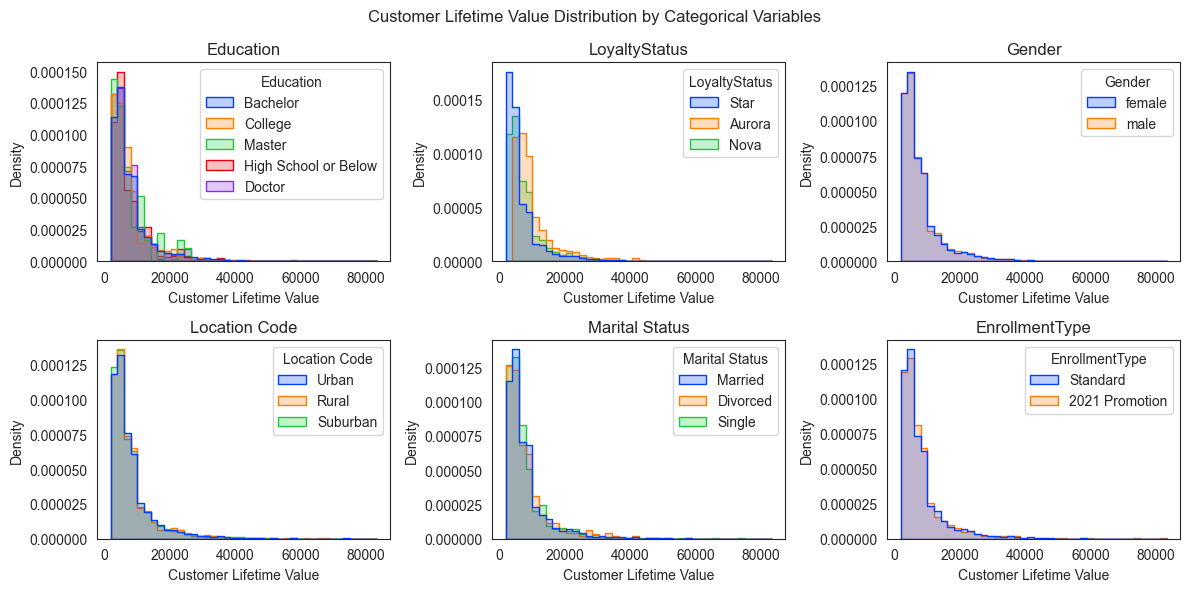

In [651]:
# plotting histogram with the CLV variable and using the categorical variables to color the data
colour_vars = ['Education', 'LoyaltyStatus', 'Gender', 'Location Code', 'Marital Status', 'EnrollmentType']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()
for i, variable in enumerate(colour_vars):
    sns.set_palette('bright')
    sns.histplot(data=customerDB_copy, x='Customer Lifetime Value', hue=variable, element='step', stat='density', common_norm=False, ax=axes[i], bins=40)
    axes[i].set_title(variable)
plt.suptitle('Customer Lifetime Value Distribution by Categorical Variables')
plt.tight_layout()
plt.show()

#### Distributions & Outliers

In [652]:
sns.set_palette('pastel')

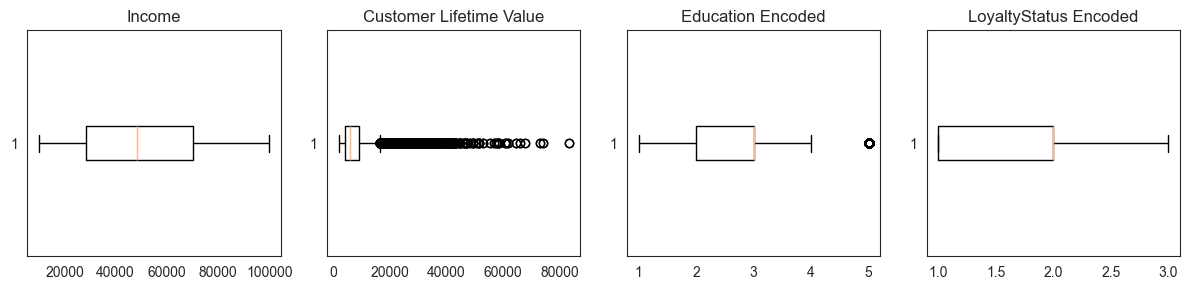

In [653]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
axes = axes.flatten()
for i, variable in enumerate(customer_numerical_variables + customer_ordinal_variables_encoded):
    axes[i].boxplot(customerDB_copy[variable].dropna(), vert=False)
    axes[i].set_title(variable)
plt.tight_layout()
plt.show()

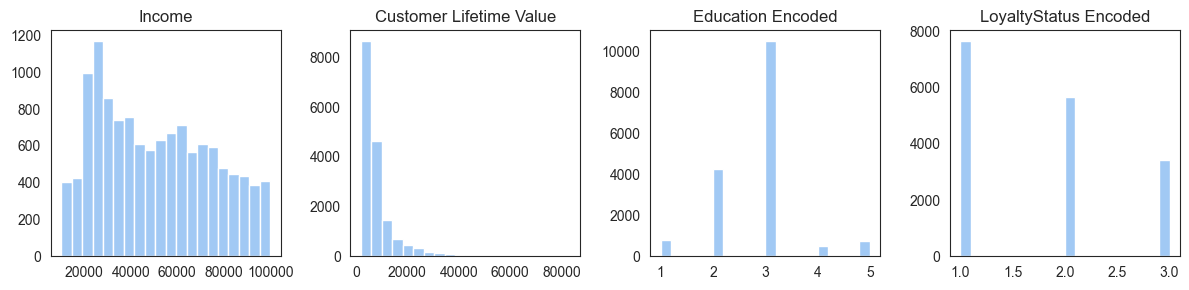

In [654]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
axes = axes.flatten()
for i, variable in enumerate(customer_numerical_variables + customer_ordinal_variables_encoded):
    axes[i].hist(customerDB_copy[variable].dropna(), bins=20)
    axes[i].set_title(variable)
plt.tight_layout()
plt.show()

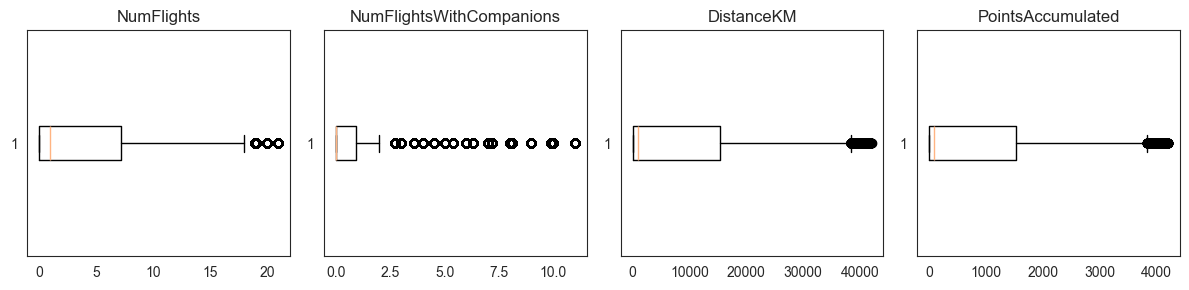

In [655]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
axes = axes.flatten()
for i, variable in enumerate(flight_numerical_variables[:-1]):
    axes[i].boxplot(flightDB_copy[variable].dropna(), vert=False)
    axes[i].set_title(variable)
plt.tight_layout()
plt.show()

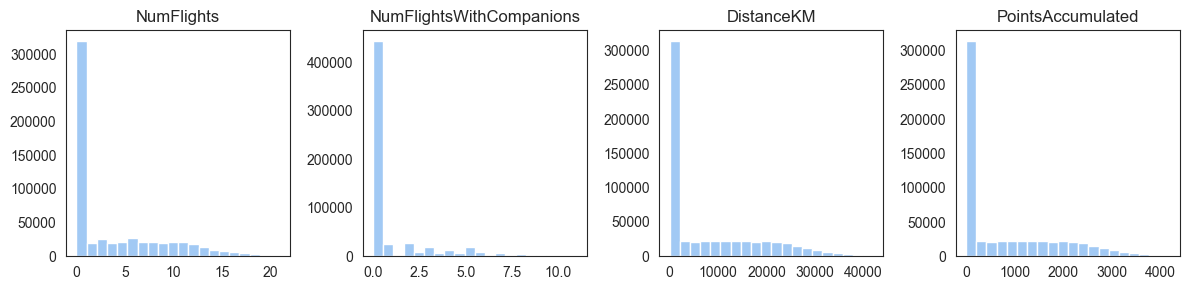

In [656]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
axes = axes.flatten()
for i, variable in enumerate(flight_numerical_variables[:-1]):
    axes[i].hist(flightDB_copy[variable].dropna(), bins=20)
    axes[i].set_title(variable)
plt.tight_layout()
plt.show()

#### Correlations

##### Numerical & Ordinal Variables

In [657]:
# CODE HERE

#
***

## 5. <a id="5">Clustering</a>

***

## 6. <a id="6">Evaluation</a>

***

## 7. <a id="7">Suggestions</a>

***